# EIS Dataset RUL Analysis

This notebook analyzes the EIS (Electrochemical Impedance Spectroscopy) dataset for battery RUL (Remaining Useful Life) prediction.

In [1]:
# Import Required Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    Input,
    Layer,
    Conv1D,
    MaxPooling1D,
    Attention,
    MultiHeadAttention,
    LayerNormalization,
    Flatten,
    Dense,
    Dropout,
    LSTM,
    BatchNormalization,
    Add,
    GlobalAveragePooling1D,
)
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

2025-09-18 00:05:04.774687: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758153904.831891   36667 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758153904.848975   36667 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Global Constants
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 1e-3
FEATURES = ['eis_real', 'eis_imag']
FREQUENCIES_MAX = None

In [3]:
# Set Base Path and Load Battery Data
eis_base_path = "/kaggle/input/eis-capacity/EIS data"
capacity_base_path = "/kaggle/input/eis-capacity/Capacity data"

temperatures = [25, 35, 45]
batteries_no = [
    [i for i in range(1, 9)],
    [1, 2],
    [1, 2],
]

class Battery:
    def __init__(self, name, df, temperature):
        self.name = name
        self.df = df
        self.temperature = temperature

    def __str__(self):
        return self.name

battery_data : list[Battery] = []
batteries : list[str] = []

In [4]:
def load_capacity_data(base_path, battery_name):
    fpath = os.path.join(base_path, f"Data_Capacity_{battery_name}" + '.txt')
    try:
        print(f"Loading capacity data for {battery_name}...")

        df = pd.read_csv(fpath, sep='\t')
        df.columns = df.columns.str.strip()
        df['cycle number'] = pd.to_numeric(df['cycle number'], errors='coerce')
        df['capacity'] = pd.to_numeric(df['Capacity/mA.h'], errors='coerce')
        df = df.dropna(subset=['cycle number', 'capacity'])

        # Transform cycle number and filter
        df['cycle number'] = df['cycle number'] * 2
        df = df[df['cycle number'] <= 500]

        # Take the last capacity of each cycle
        grouped = df.groupby('cycle number', as_index=False).last()

        first_cycle = grouped['cycle number'].min()
        init_cap = grouped[grouped['cycle number'] == first_cycle]['capacity'].max()
        # Calculate cycle at which capacity falls below 80% of initial capacity
        threshold = 0.8 * init_cap
        below_80 = grouped[grouped['capacity'] < threshold]

        if not below_80.empty:
            cycle_80 = below_80['cycle number'].iloc[0]
        else:
            cycle_80 = None

        grouped.rename(columns={'cycle number': 'cycle'}, inplace=True)

        return grouped, cycle_80

    except FileNotFoundError:
        print(f"{battery_name}: File not found.")

In [5]:
# Load data for each battery
battery_data.clear()
batteries.clear()
for temperature, batteries_number in zip(temperatures, batteries_no):
    for battery in batteries_number:
        # Read file
        battery_name = f"{temperature}C{battery:02d}"
        EIS_filename = f"EIS_state_V_{battery_name}.txt"

        batteries.append(battery_name)
        file_path = os.path.join(eis_base_path, EIS_filename)

        if temperature == 25:
            df = pd.read_csv(file_path, sep='\t') # Tab-delimited file
            df.columns = df.columns.str.strip() # Strip whitespace from column names

            # rename the columns
            df.rename(columns={'cycle number': 'cycle'}, inplace=True)
            df.rename(columns={'freq/Hz': 'frequency'}, inplace=True)
            df.rename(columns={'Re(Z)/Ohm': 'eis_real'}, inplace=True)
            df.rename(columns={'-Im(Z)/Ohm': 'eis_imag'}, inplace=True)

        else:
            df = pd.read_csv(file_path, sep='\t', header=None) # Tab-delimited file without header
            # Add header
            df.columns = ['time/s', 'cycle', 'frequency', 'eis_real', 'eis_imag', '|Z|/Ohm', 'Phase(Z)/deg']

        # Multiply cycle number by 2 because the measurements are taken in even-numbered cycles
        df['cycle'] = (df['cycle'] - 1) * 2

        # get capacity data and end of life (EOL)
        capacity_df, eol = load_capacity_data(capacity_base_path, battery_name)
        if eol is None:
            eol = df['cycle'].max()  # If no EOL found, use max cycle in EIS data

        print(f"Battery {battery_name}: EOL at cycle {eol}, max cycle in EIS data {df['cycle'].max()}")
        # Calculate Remaining Useful Life
        df['RUL'] = eol - df['cycle']
        # drop rows with negative or zero RUL
        df = df[df['RUL'] >= 0]
        df['temperature'] = temperature
        df['battery'] = battery_name
        # append capacity data
        df = pd.merge(df, capacity_df[['cycle', 'capacity']], on='cycle', how='left')

        battery_data.append(Battery(battery_name, df, temperature)) # Append battery data
        print(f"Loaded {EIS_filename}: {len(df):>5} rows")

print(f"\nLoaded {len(battery_data)} battery datasets")

Loading capacity data for 25C01...
Battery 25C01: EOL at cycle 234.0, max cycle in EIS data 520.0
Loaded EIS_state_V_25C01.txt:  7080 rows
Loading capacity data for 25C02...
Battery 25C02: EOL at cycle 12.0, max cycle in EIS data 498.0
Loaded EIS_state_V_25C02.txt:   420 rows
Loading capacity data for 25C03...
Battery 25C03: EOL at cycle 164.0, max cycle in EIS data 456.0
Loaded EIS_state_V_25C03.txt:  4980 rows
Loading capacity data for 25C04...
Battery 25C04: EOL at cycle 160.0, max cycle in EIS data 160.0
Loaded EIS_state_V_25C04.txt:  4860 rows
Loading capacity data for 25C05...
Battery 25C05: EOL at cycle 152.0, max cycle in EIS data 548.0
Loaded EIS_state_V_25C05.txt:  4620 rows
Loading capacity data for 25C06...
Battery 25C06: EOL at cycle 120.0, max cycle in EIS data 422.0
Loaded EIS_state_V_25C06.txt:  3660 rows
Loading capacity data for 25C07...
Battery 25C07: EOL at cycle 32.0, max cycle in EIS data 278.0
Loaded EIS_state_V_25C07.txt:  1020 rows
Loading capacity data for 25C

In [6]:
sample_battery = battery_data[0]
print(f"Sample data: {sample_battery}")
print(sample_battery.df.head())
print(sample_battery.df.info())

Sample data: 25C01
        time/s  cycle   frequency  eis_real  eis_imag  |Z|/Ohm  Phase(Z)/deg  \
0  12836.72676    0.0  20004.4530   0.38470  -0.03513  0.38630       5.21784   
1  12836.86976    0.0  15829.1260   0.39156  -0.01700  0.39193       2.48562   
2  12837.01176    0.0  12516.7030   0.39684   0.00009  0.39684      -0.01302   
3  12837.15376    0.0   9909.4424   0.40341   0.01405  0.40365      -1.99482   
4  12837.31776    0.0   7835.4800   0.40963   0.02612  0.41046      -3.64787   

     RUL  temperature battery   capacity  
0  234.0           25   25C01  37.202713  
1  234.0           25   25C01  37.202713  
2  234.0           25   25C01  37.202713  
3  234.0           25   25C01  37.202713  
4  234.0           25   25C01  37.202713  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7080 entries, 0 to 7079
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   time/s        7080 non-null   float64
 1   c

# Visualize Data

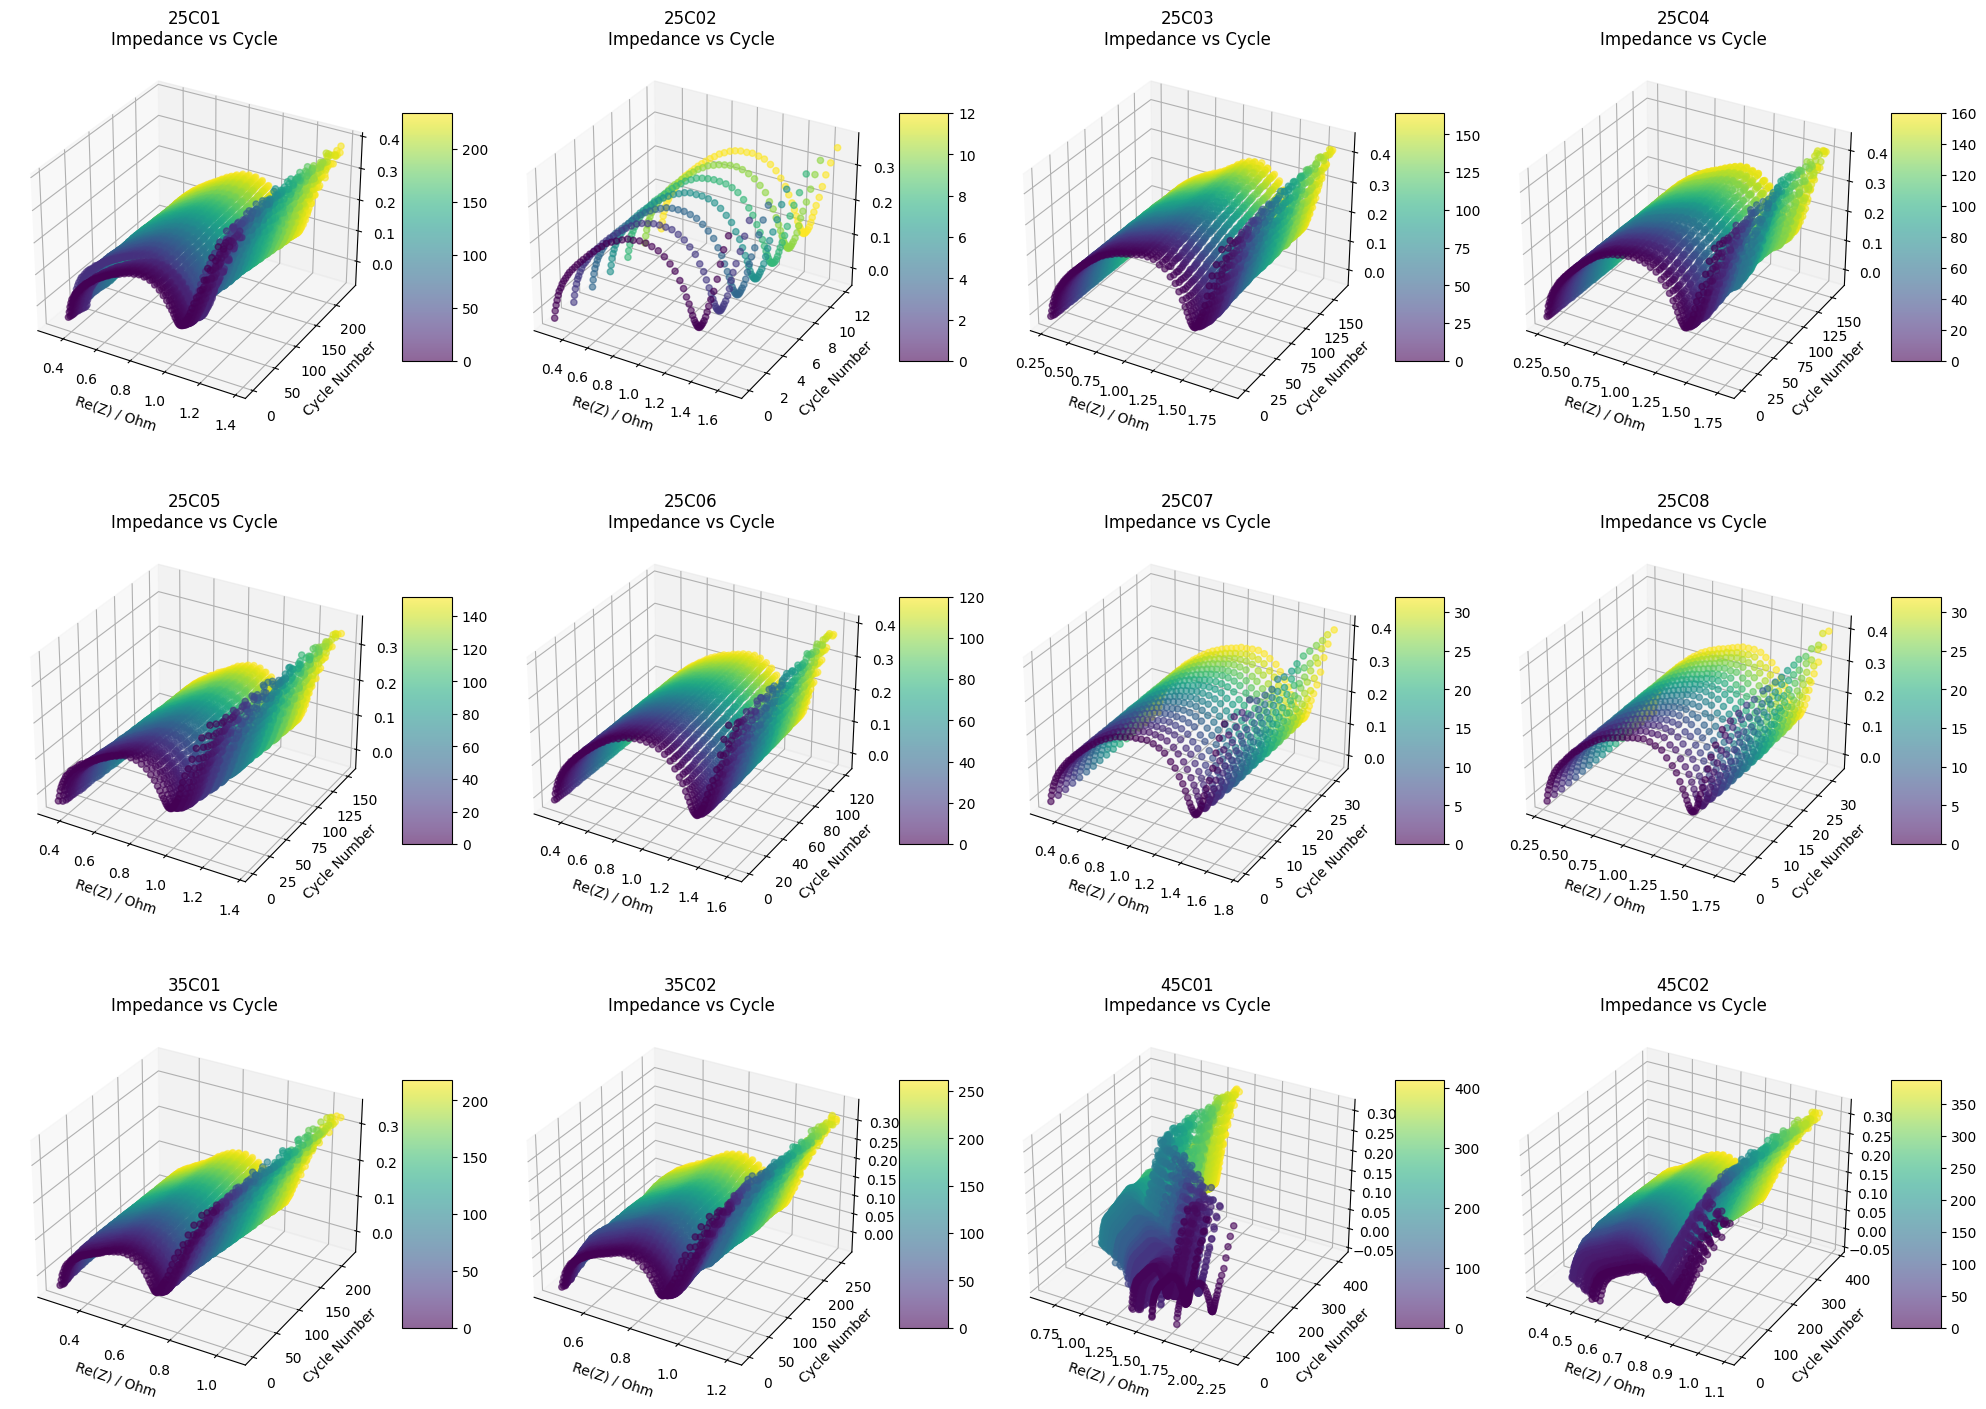

In [7]:
# Create 3D Plots for Each Battery
fig = plt.figure(figsize=(20, 15))

plot_num = 1
for battery in battery_data:
    ax = fig.add_subplot(3, 4, plot_num, projection='3d')
    
    # Create 3D scatter plot
    scatter = ax.scatter(battery.df['eis_real'], battery.df['cycle'], battery.df['eis_imag'],
                         c=battery.df['cycle'], cmap='viridis', alpha=0.6)
    
    ax.set_xlabel('Re(Z) / Ohm')
    ax.set_zlabel('-Im(Z) / Ohm')
    ax.set_ylabel('Cycle Number')
    ax.set_title(f'{battery.name}\nImpedance vs Cycle')
    
    # Add colorbar
    plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)
    
    plot_num += 1

plt.tight_layout()
plt.show()

# Prepare training and testing datasets

In [8]:
def prepare_flatten_dataset(
    batteries : list[Battery],
    battery_names : list[str],
    features = ['eis_imag'],
    frequencies_min=0,
    frequencies_max=None,
):
    X_list = []
    y_list = []
    for battery in batteries:
        if battery.name not in battery_names:
            continue

        df = battery.df.copy()
        # Pivot the data to have frequencies as columns
        pivot_df = df.pivot(
            index='RUL',
            columns='frequency',
            values=features
        )

        if frequencies_min is not None and frequencies_max is not None:
            freq_filter = (
                (pivot_df.columns.get_level_values(1) >= frequencies_min) & 
                (pivot_df.columns.get_level_values(1) <= frequencies_max)
            )
            pivot_df = pivot_df.loc[:, freq_filter]

        # Rename columns
        pivot_df.columns = [f'{stat}_{freq}' for stat, freq in pivot_df.columns]
        pivot_df = pivot_df.reset_index()

        # Separate features and target
        X = pivot_df.drop(columns=['RUL']).values.astype(np.float32)
        y = pivot_df['RUL'].values.astype(np.float32)

        X_list.append(X)
        y_list.append(y)

        # # Output to new file
        # output_df = pd.DataFrame(X, columns=pivot_df.columns[1:])
        # output_df['RUL'] = y
        # output_filename = f"{battery.name}_flattened.csv"
        # output_df.to_csv(output_filename, index=False)
        # print(f"Saved flattened data for {battery.name} to {output_filename}")
    
    # Concatenate all batteries' data
    X_all = np.vstack(X_list)
    y_all = np.hstack(y_list)

    return X_all, y_all

In [9]:
def prepare_3d_dataset(
    batteries : list[Battery], 
    battery_names : list[str], 
    features = ['eis_imag'],
    frequencies_min=0,
    frequencies_max=None,
):
    X_list = []
    y_list = []

    for battery in batteries:
        if battery.name in battery_names:
            df = battery.df.copy()

            # Pivot so each frequency is a feature
            pivot_df = df.pivot(
                index='RUL',
                columns='frequency',
                values=features
            )

            if frequencies_min is not None and frequencies_max is not None:
                freq_filter = (
                    (pivot_df.columns.get_level_values(1) >= frequencies_min) & 
                    (pivot_df.columns.get_level_values(1) <= frequencies_max)
                )
                pivot_df = pivot_df.loc[:, freq_filter]
            
            # Extract target
            rul = pivot_df.index.values.astype(np.float32)

            # Build feature tensor by stacking requested features along last axis
            channel_arrays = []
            # If only one feature requested, pandas will drop the level and .loc works differently; use get_level_values check
            if isinstance(pivot_df.columns, pd.MultiIndex):
                col_stats = pivot_df.columns.get_level_values(0)
                for feat in features:
                    if feat not in col_stats:
                        raise KeyError(f"Feature '{feat}' not found in pivoted columns")
                    channel_arrays.append(pivot_df[feat].values)
            else:
                # Single feature case → pivot_df already 3d with columns=freqs
                channel_arrays.append(pivot_df.values)

            eis_values = np.stack(channel_arrays, axis=-1).astype(np.float32)

            X_list.append(eis_values)
            y_list.append(rul)

    # Merge across batteries
    X_all = np.vstack(X_list)
    y_all = np.hstack(y_list)

    return X_all, y_all

In [10]:
class StandardScaler3D():
    def __init__(self):
        self.mean_ = None
        self.scale_ = None

    def fit(self, X):
        self.mean_ = np.mean(X, axis=0, keepdims=True)
        self.scale_ = np.std(X, axis=0, keepdims=True)
        self.scale_[self.scale_ == 0] = 1.0  # Prevent division by zero

    def transform(self, X):
        return (X - self.mean_) / self.scale_
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [11]:
def log_scale(y):
    """Apply log scaling: log(1 + y)"""
    return np.log1p(y) 

def log_inverse(y_scaled):
    """Inverse transform: exp(y) - 1"""
    return np.expm1(y_scaled)

In [12]:
X, y = prepare_flatten_dataset(
    battery_data,
    ["25C01"],
    frequencies_max=20
)

print("X shape:", X.shape)
print("y shape:", y.shape)
print("First X sample:\n", X[0])
print("First y sample:", y[0])

X shape: (118, 30)
y shape: (118,)
First X sample:
 [0.35617 0.31418 0.27585 0.23698 0.20377 0.18    0.15599 0.13447 0.11447
 0.09826 0.08718 0.08007 0.0734  0.06831 0.06502 0.06548 0.06564 0.06772
 0.07111 0.07749 0.08586 0.09607 0.10803 0.12565 0.1412  0.1603  0.17767
 0.19228 0.20306 0.20905]
First y sample: 0.0


In [13]:
X, y = prepare_3d_dataset(
    battery_data,
    ["25C01"],
    frequencies_max=20,
)
print("X shape:", X.shape)
print("y shape:", y.shape)
print("First X sample:\n", X[0])
print("First y sample:", y[0])

X shape: (118, 30, 1)
y shape: (118,)
First X sample:
 [[0.35617]
 [0.31418]
 [0.27585]
 [0.23698]
 [0.20377]
 [0.18   ]
 [0.15599]
 [0.13447]
 [0.11447]
 [0.09826]
 [0.08718]
 [0.08007]
 [0.0734 ]
 [0.06831]
 [0.06502]
 [0.06548]
 [0.06564]
 [0.06772]
 [0.07111]
 [0.07749]
 [0.08586]
 [0.09607]
 [0.10803]
 [0.12565]
 [0.1412 ]
 [0.1603 ]
 [0.17767]
 [0.19228]
 [0.20306]
 [0.20905]]
First y sample: 0.0


# Model definition

In [14]:
regularizer = tf.keras.regularizers.l2(0.01)

# Build the Neural Network Model
def create_ann_model(input_dim):
    """Create an Artificial Neural Network for RUL prediction"""
    model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(16, activation='linear'),
        keras.layers.Dense(1)
    ])
    return model

class SAM(Layer):
    # Self attention layer, no multihead
    def __init__(self, key_dim, dropout):
        super(SAM, self).__init__()
        self.q = Dense(key_dim, kernel_regularizer=regularizer)
        self.k = Dense(key_dim, kernel_regularizer=regularizer)
        self.v = Dense(key_dim, kernel_regularizer=regularizer)
        self.dropout = Dropout(dropout)

    def call(self, inputs):
        q = self.q(inputs)
        k = self.k(inputs)
        v = self.v(inputs)
        attention_output = Attention()([q, k, v])
        attention_output = self.dropout(attention_output)
        return attention_output

def create_cnn_sam_model(input_shape):
    """Create CNN-SAM model for RUL prediction"""
    inputs = Input(shape=input_shape)

    # CNN layers
    x = Conv1D(filters=80, kernel_size=10, activation='relu', kernel_regularizer=regularizer, padding='same')(inputs)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(filters=80, kernel_size=6, activation='relu', kernel_regularizer=regularizer, padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(filters=80, kernel_size=6, activation='relu', kernel_regularizer=regularizer, padding='same')(x)
    x = MaxPooling1D(pool_size=2)(x)

    x = Conv1D(filters=80, kernel_size=3, activation='relu', kernel_regularizer=regularizer, padding='same')(x)

    # SAM Layer
    # attention_output = MultiHeadAttention(num_heads=8, key_dim=10, dropout=0.1)(x, x)
    attention_output = SAM(key_dim=80, dropout=0.1)(x)
    attention_pooled = GlobalAveragePooling1D()(attention_output)
    x_pooled = GlobalAveragePooling1D()(x)
    x = LayerNormalization()(x_pooled + attention_pooled)

    # Flatten, FC layers
    x = Flatten()(x)
    x = Dense(128, activation='relu', kernel_regularizer=regularizer)(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu', kernel_regularizer=regularizer)(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1, activation='linear', kernel_regularizer=regularizer)(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model


def create_lstm_model(input_shape):
    """
    Larger LSTM model for RUL prediction
    """
    inputs = Input(shape=input_shape)

    # First LSTM layer
    x = LSTM(256, return_sequences=True, kernel_regularizer=regularizer)(inputs)
    x = Dropout(0.3)(x)

    # Second LSTM layer
    x = LSTM(128, return_sequences=True, kernel_regularizer=regularizer)(x)
    x = Dropout(0.3)(x)

    # Third LSTM layer (final, no return_sequences)
    x = LSTM(64, return_sequences=False, kernel_regularizer=regularizer)(x)
    x = Dropout(0.2)(x)

    # Dense layers
    x = Dense(128, activation='relu', kernel_regularizer=regularizer)(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu', kernel_regularizer=regularizer)(x)

    # Output
    outputs = Dense(1, activation='linear')(x)

    model = Model(inputs, outputs)
    return model

def create_cnn_lstm_model(input_shape):
    # CNN + LSTM hybrid model for RUL prediction from EIS    
    inputs = Input(shape=input_shape)

    # CNN feature extractor
    x = Conv1D(128, kernel_size=5, activation='relu',
               padding='same', kernel_regularizer=regularizer)(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv1D(128, kernel_size=3, activation='relu',
               padding='same', kernel_regularizer=regularizer)(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization()(x)

    # Sequence modeling with LSTM
    x = LSTM(128, return_sequences=True, kernel_regularizer=regularizer)(x)
    x = Dropout(0.3)(x)
    x = LSTM(64, return_sequences=False, kernel_regularizer=regularizer)(x)
    x = Dropout(0.3)(x)

    # Fully connected layers
    x = Dense(64, activation='relu', kernel_regularizer=regularizer)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu', kernel_regularizer=regularizer)(x)

    # Output regression for RUL
    outputs = Dense(1, activation='linear')(x)

    model = Model(inputs, outputs)
    return model

def create_cnn_lstm_attention_model(input_shape=(60, 2)):
    inputs = Input(shape=input_shape)

    # CNN feature extractor
    x = Conv1D(16, kernel_size=5, activation='relu',
               padding='same', kernel_regularizer=regularizer)(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization()(x)
    x = Conv1D(32, kernel_size=3, activation='relu',
               padding='same', kernel_regularizer=regularizer)(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization()(x)
          
    # LSTM sequence encoder
    x = LSTM(128, return_sequences=True, kernel_regularizer=regularizer)(x)
    x = Dropout(0.2)(x)
    x = LSTM(64, return_sequences=True, kernel_regularizer=regularizer)(x)
    x = Dropout(0.2)(x)
    x = LSTM(32, return_sequences=True, kernel_regularizer=regularizer)(x)
    x = Dropout(0.2)(x)
    x = LSTM(16, return_sequences=True, kernel_regularizer=regularizer)(x)
    x = Dropout(0.2)(x)
    # Attention layer
    # Self-attention: query = key = value = x
    # attention_output = Attention()([x, x])

    # Multi-head
    attention_output = MultiHeadAttention(num_heads=4, key_dim=32)(x, x)
    x = keras.layers.GlobalAveragePooling1D()(attention_output)
   
    # Fully connected layers
    x = Dense(16, activation='relu', kernel_regularizer=regularizer)(x)
    x = Dropout(0.2)(x)
    # x = Dense(64, activation='relu', kernel_regularizer=regularizer)(x)

    # Output regression for RUL
    outputs = Dense(1, activation='linear')(x)

    model = Model(inputs, outputs)
    return model

regularizer = tf.keras.regularizers.l2(1e-4)

def transformer_block(x, num_heads=4, key_dim=32, ff_dim=64, dropout=0.2):
    """Transformer encoder block with MHA + FFN"""
    # Multi-head self-attention
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    attn_output = Dropout(dropout)(attn_output)
    out1 = Add()([x, attn_output])           # Residual connection
    out1 = LayerNormalization()(out1)

    # Feed-forward network
    ffn = Dense(ff_dim, activation="relu")(out1)
    ffn = Dense(x.shape[-1])(ffn)
    ffn = Dropout(dropout)(ffn)
    out2 = Add()([out1, ffn])                # Residual connection
    out2 = LayerNormalization()(out2)

    return out2

def create_cnn_lstm_transformer_model(input_shape=(60, 2)):
    inputs = Input(shape=input_shape)

    # CNN feature extractor
    x = Conv1D(32, kernel_size=5, activation='relu',
               padding='same', kernel_regularizer=regularizer)(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv1D(64, kernel_size=3, activation='relu',
               padding='same', kernel_regularizer=regularizer)(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization()(x)

    # LSTM sequence encoder
    x = LSTM(64, return_sequences=True, kernel_regularizer=regularizer)(x)
    x = Dropout(0.2)(x)
    x = LSTM(32, return_sequences=True, kernel_regularizer=regularizer)(x)
    x = Dropout(0.2)(x)
    # x = LSTM(16, return_sequences=True, kernel_regularizer=regularizer)(x)
    # x = Dropout(0.2)(x)
    
    # Transformer block(s)
    x = transformer_block(x, num_heads=4, key_dim=64, ff_dim=128, dropout=0.2)
    x = transformer_block(x, num_heads=4, key_dim=64, ff_dim=128, dropout=0.2)  # stacked for more power
    x = transformer_block(x, num_heads=4, key_dim=64, ff_dim=128, dropout=0.2)
    
    # Pooling over time dimension
    x = GlobalAveragePooling1D()(x)

    # Fully connected layers
    x = Dense(32, activation='relu', kernel_regularizer=regularizer)(x)
    x = Dropout(0.2)(x)

    # Output regression for RUL
    outputs = Dense(1, activation='linear')(x)

    model = Model(inputs, outputs)
    return model

regularizer = tf.keras.regularizers.l2(1e-4)

def transformer_block(x, num_heads=4, key_dim=32, ff_dim=64, dropout=0.2):
    """Transformer encoder block with MHA + FFN"""
    # Multi-head self-attention
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    attn_output = Dropout(dropout)(attn_output)
    out1 = Add()([x, attn_output])           
    out1 = LayerNormalization()(out1)

    # Feed-forward network
    ffn = Dense(ff_dim, activation="relu")(out1)
    ffn = Dense(x.shape[-1])(ffn)
    ffn = Dropout(dropout)(ffn)
    out2 = Add()([out1, ffn])                
    out2 = LayerNormalization()(out2)

    return out2

def create_cnn_transformer_model(input_shape=(60, 2)):
    inputs = Input(shape=input_shape)

    # CNN feature extractor
    x = Conv1D(32, kernel_size=5, activation='relu',
               padding='same', kernel_regularizer=regularizer)(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization()(x)

    x = Conv1D(64, kernel_size=3, activation='relu',
               padding='same', kernel_regularizer=regularizer)(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = BatchNormalization()(x)

    # Transformer sequence encoder (instead of LSTMs)
    x = transformer_block(x, num_heads=4, key_dim=32, ff_dim=64, dropout=0.2)
    x = transformer_block(x, num_heads=4, key_dim=32, ff_dim=64, dropout=0.2)
    x = transformer_block(x, num_heads=4, key_dim=32, ff_dim=64, dropout=0.2)

    # Pooling over time dimension
    x = GlobalAveragePooling1D()(x)

    # Fully connected layers
    x = Dense(32, activation='relu', kernel_regularizer=regularizer)(x)
    x = Dropout(0.2)(x)

    # Output regression for RUL
    outputs = Dense(1, activation='linear')(x)

    model = Model(inputs, outputs)
    return model

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6
)

# Select Training and Testing Batteries

In [15]:
# Split train test
training_batteries = [f'25C{i:02d}' for i in [1, 2, 3, 4]]
training_batteries += ['35C01', '45C01']
testing_batteries = ['25C05', '35C02', '45C02']

print("Training Batteries:")
print(training_batteries)
print("Testing Batteries:")
print(testing_batteries)

Training Batteries:
['25C01', '25C02', '25C03', '25C04', '35C01', '45C01']
Testing Batteries:
['25C05', '35C02', '45C02']


# Prepare datasets

In [16]:
# # Augmentation: Gaussian noise
def augment_gaussian_fraction(X, y, frac=0.02, n_aug=1, seed=42):
    """Augment X by adding gaussian noise with std = frac * per-feature std.
    Works for 3d and 3D arrays (noise shaped like X)."""
    np.random.seed(seed)
    if n_aug <= 0 or frac <= 0:
        return X, y
    X_list = [X]
    y_list = [y]
    base_std = np.std(X, axis=0, keepdims=True)
    base_std[base_std == 0] = 1e-8
    for _ in range(n_aug):
        noise = np.random.normal(0, 1, size=X.shape) * (base_std * frac)
        X_list.append(X + noise)
        y_list.append(y.copy())
    return np.concatenate(X_list, axis=0), np.concatenate(y_list, axis=0)

# Tune these two values to control how much augmentation occurs
n_augmentations = 2  # number of noisy copies to add (total multiplier = 1 + n_augmentations)
noise_fraction = 0.02  # std of noise relative to each feature's std

In [17]:
# 1) Flatten
X_train_flat, y_train_flat = prepare_flatten_dataset(
    battery_data,
    training_batteries,
    features=FEATURES,
    frequencies_max=FREQUENCIES_MAX,
)

X_test_flat, y_test_flat = prepare_flatten_dataset(
    battery_data,
    testing_batteries,
    features=FEATURES,
    frequencies_max=FREQUENCIES_MAX
)

# Normalization
scaler_flatten = StandardScaler()
X_train_flat = scaler_flatten.fit_transform(X_train_flat)
X_test_flat = scaler_flatten.transform(X_test_flat)
print("After standardization:")
print(np.std(X_train_flat, axis=0))

# Augmentation
X_train_flat, y_train_flat = augment_gaussian_fraction(X_train_flat, y_train_flat, frac=noise_fraction, n_aug=n_augmentations)

After standardization:
[1.         1.         1.         0.99999994 1.         1.
 1.         1.         1.         1.         1.         0.99999994
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 0.99999994 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         0.99999994 1.         0.99999994 0.99999994
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.99999994 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.   

In [18]:
print("Shape of training data (flattened):", X_train_flat.shape)
print("Shape of testing data (flattened):", X_test_flat.shape)

Shape of training data (flattened): (1821, 120)
Shape of testing data (flattened): (404, 120)


In [19]:
train_flat_ds = (
    tf.data.Dataset.from_tensor_slices((X_train_flat, log_scale(y_train_flat)))
    .shuffle(buffer_size=len(X_train_flat))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
test_flat_ds = (
    tf.data.Dataset.from_tensor_slices((X_test_flat, log_scale(y_test_flat)))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

2025-09-18 00:05:36.208747: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [20]:
# 2) 3d
X_train_3d, y_train_3d = prepare_3d_dataset(
    battery_data,
    training_batteries,
    features=FEATURES,
    frequencies_max=FREQUENCIES_MAX
)

X_test_3d, y_test_3d = prepare_3d_dataset(
    battery_data,
    testing_batteries,
    features=FEATURES,
    frequencies_max=FREQUENCIES_MAX
)

# Normalization
scaler_3d = StandardScaler3D()
X_train_3d = scaler_3d.fit_transform(X_train_3d)
X_test_3d = scaler_3d.transform(X_test_3d)

# Augmentation
X_train_3d, y_train_3d = augment_gaussian_fraction(X_train_3d, y_train_3d, frac=noise_fraction, n_aug=n_augmentations)

In [21]:
print("Shape of training data (3d):", X_train_3d.shape)
print("Shape of testing data (3d):", X_test_3d.shape)

Shape of training data (3d): (1821, 60, 2)
Shape of testing data (3d): (404, 60, 2)


In [22]:
train_3d_ds = (
    tf.data.Dataset.from_tensor_slices((X_train_3d, log_scale(y_train_3d)))
    .shuffle(buffer_size=len(X_train_3d))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
test_3d_ds = (
    tf.data.Dataset.from_tensor_slices((X_test_3d, log_scale(y_test_3d)))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [23]:
std_flat = np.std(X_train_flat, axis=0, keepdims=True)
print(std_flat)
print(std_flat.shape)

std_3d = np.std(X_train_3d, axis=0, keepdims=True)
print(std_3d)
print(std_3d.shape)

[[1.00006235 1.0002946  1.00031272 1.00107179 1.00030747 0.99902862
  0.99991452 0.99938388 1.00026722 1.00009732 0.9998945  1.00076226
  1.00057608 0.99978705 0.99919297 1.00086415 1.00062071 1.00018976
  1.00004134 0.99975702 0.99970036 1.00032788 1.00050192 1.00069306
  1.00027861 0.99956387 0.99996426 0.99920479 1.00032264 0.99990731
  1.00006254 1.00008811 1.00109639 1.0003593  1.00038351 1.00019742
  1.00056581 0.999797   1.00069817 1.00047466 1.00026549 1.00031767
  0.99966708 0.99944053 1.00041448 1.0006456  1.00055848 0.99998844
  1.00035419 1.00049794 0.99996339 1.00013059 1.00017406 1.00049964
  0.99996793 1.00047501 1.00029537 0.99991484 1.00057924 1.000157
  1.00015166 1.00042602 0.99991312 0.99990328 0.99951469 0.99973815
  0.99993606 0.9997098  1.00055064 0.99957138 1.0003892  0.99984769
  1.00025219 1.00000739 1.00055882 0.99976707 1.00025236 1.00054722
  0.99989428 1.00016607 1.00059783 0.99991247 1.00048581 1.00036627
  1.0002885  0.99972627 1.00020142 1.00110526 1.00

# Training Models

In [24]:
model_info = {}

In [25]:
def train_and_evaluate(model_fn, name, input_shape, 
                       train_ds, test_ds, 
                       X_test, y_test, scaler):
    model = model_fn(input_shape)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  loss='mae', metrics=['mae'])
    history = model.fit(train_ds, validation_data=test_ds,
                        epochs=EPOCHS, verbose=1,
                        callbacks=[early_stopping, reduce_lr])
    
    y_pred = model.predict(X_test).flatten()
    y_pred = log_inverse(y_pred)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    global model_info
    model_info[name] = {
        'model': model,
        'scaler': scaler,
        'history': history,
        'results': (y_test, y_pred),
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

    print(f"\n{name} Performance:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R² Score: {r2:.4f}")

In [26]:
train_and_evaluate(
    model_fn=create_ann_model,
    name="ANN",
    input_shape=X_train_flat.shape[1],
    train_ds=train_flat_ds,
    test_ds=test_flat_ds,
    X_test=X_test_flat,
    y_test=y_test_flat,
    scaler=scaler_flatten
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 2.7033 - mae: 2.7033 - val_loss: 1.8131 - val_mae: 1.8131 - learning_rate: 0.0010
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1744 - mae: 1.1744 - val_loss: 1.1157 - val_mae: 1.1157 - learning_rate: 0.0010
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0501 - mae: 1.0501 - val_loss: 1.1069 - val_mae: 1.1069 - learning_rate: 0.0010
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9813 - mae: 0.9813 - val_loss: 1.2553 - val_mae: 1.2553 - learning_rate: 0.0010
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9226 - mae: 0.9226 - val_loss: 0.7416 - val_mae: 0.7416 - learning_rate: 0.0010
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8823 - mae: 0.8823 - val_loss: 1.1311 - val_mae: 1.1311 - learning_rate: 0.0010
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8394 - mae: 0.8394 - val_loss: 1.0742 - val_mae: 1.0742 - learning_rate: 0.0010
Epoch 8/100
5

In [27]:
train_and_evaluate(
    create_cnn_sam_model,
    "CNN-SAM",
    input_shape=X_train_3d.shape[1:],
    train_ds=train_3d_ds,
    test_ds=test_3d_ds,
    X_test=X_test_3d,
    y_test=y_test_3d,
    scaler=scaler_3d
)

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - loss: 1.7179 - mae: 1.6550 - val_loss: 0.9453 - val_mae: 0.8908 - learning_rate: 0.0010
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.0868 - mae: 1.0339 - val_loss: 0.8992 - val_mae: 0.8501 - learning_rate: 0.0010
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.9978 - mae: 0.9494 - val_loss: 0.7849 - val_mae: 0.7381 - learning_rate: 0.0010
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.9021 - mae: 0.8556 - val_loss: 0.7360 - val_mae: 0.6904 - learning_rate: 0.0010
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.8381 - mae: 0.7925 - val_loss: 0.7570 - val_mae: 0.7119 - learning_rate: 0.0010
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.8085 - mae: 0.7635 - val_loss: 0.7235 - val_mae: 0.6790 - learning_rate: 0.0010
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.7818 - mae: 0.7375 - val_loss: 0.6339 - val_mae: 0.5902 - learning_rate: 0.0010
Epoch 

In [28]:
train_and_evaluate(
    create_lstm_model,
    "LSTM",
    input_shape=X_train_3d.shape[1:],
    train_ds=train_3d_ds,
    test_ds=test_3d_ds,
    X_test=X_test_3d,
    y_test=y_test_3d,
    scaler=scaler_3d,
)

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 226ms/step - loss: 2.3554 - mae: 2.2879 - val_loss: 1.2637 - val_mae: 1.1978 - learning_rate: 0.0010
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 211ms/step - loss: 0.9848 - mae: 0.9201 - val_loss: 0.8379 - val_mae: 0.7767 - learning_rate: 0.0010
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 211ms/step - loss: 0.8993 - mae: 0.8392 - val_loss: 0.7094 - val_mae: 0.6526 - learning_rate: 0.0010
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 210ms/step - loss: 0.8966 - mae: 0.8408 - val_loss: 0.8227 - val_mae: 0.7696 - learning_rate: 0.0010
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 209ms/step - loss: 0.8520 - mae: 0.7997 - val_loss: 0.7865 - val_mae: 0.7366 - learning_rate: 0.0010
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 212ms/step - loss: 0.8620 - mae: 0.8128 - val_loss: 0.8123 - val_mae: 0.7650 - learning_rate: 0.0010
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 12s 213ms/step - loss: 0.7983 - mae: 0.7515 - val_loss: 0.8067 - val_mae: 0.7614 - learning_rate:

In [29]:
train_and_evaluate(create_cnn_lstm_model, "CNN+LSTM", 
                   (X_train_3d.shape[1], X_train_3d.shape[2]), 
                   train_3d_ds, test_3d_ds, X_test_3d, y_test_3d, scaler_3d)

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 52ms/step - loss: 2.1939 - mae: 2.1323 - val_loss: 1.4376 - val_mae: 1.3754 - learning_rate: 0.0010
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.9833 - mae: 0.9211 - val_loss: 1.1147 - val_mae: 1.0527 - learning_rate: 0.0010
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.8795 - mae: 0.8176 - val_loss: 0.9433 - val_mae: 0.8814 - learning_rate: 0.0010
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.8499 - mae: 0.7879 - val_loss: 1.0046 - val_mae: 0.9425 - learning_rate: 0.0010
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 0.7557 - mae: 0.6935 - val_loss: 0.8298 - val_mae: 0.7676 - learning_rate: 0.0010
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.6741 - mae: 0.6120 - val_loss: 0.6797 - val_mae: 0.6176 - learning_rate: 0.0010
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.6618 - mae: 0.5997 - val_loss: 0.8131 - val_mae: 0.7511 - learning_rate: 0.0010
Epoch

In [30]:
train_and_evaluate(create_cnn_lstm_attention_model, "CNN+LSTM+Attention", 
                   (X_train_3d.shape[1], X_train_3d.shape[2]), 
                   train_3d_ds, test_3d_ds, X_test_3d, y_test_3d, scaler_3d)

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - loss: 3.4001 - mae: 3.3614 - val_loss: 0.9672 - val_mae: 0.9288 - learning_rate: 0.0010
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 1.0983 - mae: 1.0604 - val_loss: 0.7646 - val_mae: 0.7284 - learning_rate: 0.0010
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 1.0855 - mae: 1.0498 - val_loss: 0.7613 - val_mae: 0.7272 - learning_rate: 0.0010
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 1.0127 - mae: 0.9790 - val_loss: 0.7321 - val_mae: 0.6995 - learning_rate: 0.0010
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.9633 - mae: 0.9309 - val_loss: 0.6414 - val_mae: 0.6095 - learning_rate: 0.0010
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.9101 - mae: 0.8784 - val_loss: 0.6971 - val_mae: 0.6661 - learning_rate: 0.0010
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.8838 - mae: 0.8529 - val_loss: 0.6572 - val_mae: 0.6267 - learning_rate: 0.0010
Epoch

In [31]:
train_and_evaluate(create_cnn_lstm_transformer_model, "CNN+LSTM+Transformer", 
                   (X_train_3d.shape[1], X_train_3d.shape[2]), 
                   train_3d_ds, test_3d_ds, X_test_3d, y_test_3d, scaler_3d)

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 28s 74ms/step - loss: 1.4793 - mae: 1.4528 - val_loss: 0.6565 - val_mae: 0.6302 - learning_rate: 0.0010
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.8744 - mae: 0.8481 - val_loss: 0.6675 - val_mae: 0.6413 - learning_rate: 0.0010
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.7317 - mae: 0.7055 - val_loss: 0.9882 - val_mae: 0.9621 - learning_rate: 0.0010
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.7465 - mae: 0.7205 - val_loss: 0.7487 - val_mae: 0.7228 - learning_rate: 0.0010
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.6647 - mae: 0.6388 - val_loss: 0.7439 - val_mae: 0.7181 - learning_rate: 0.0010
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 0.6549 - mae: 0.6292 - val_loss: 0.6504 - val_mae: 0.6248 - learning_rate: 0.0010
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.6758 - mae: 0.6503 - val_loss: 0.7254 - val_mae: 0.6999 - learning_rate: 0.0010
Epoch

In [32]:
train_and_evaluate(create_cnn_transformer_model, "CNN+Transformer", 
                   (X_train_3d.shape[1], X_train_3d.shape[2]), 
                   train_3d_ds, test_3d_ds, X_test_3d, y_test_3d, scaler_3d)

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - loss: 1.5802 - mae: 1.5712 - val_loss: 0.6557 - val_mae: 0.6468 - learning_rate: 0.0010
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.8858 - mae: 0.8769 - val_loss: 1.3610 - val_mae: 1.3521 - learning_rate: 0.0010
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.8502 - mae: 0.8412 - val_loss: 0.5505 - val_mae: 0.5415 - learning_rate: 0.0010
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.7176 - mae: 0.7086 - val_loss: 0.6038 - val_mae: 0.5948 - learning_rate: 0.0010
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.7099 - mae: 0.7010 - val_loss: 0.6490 - val_mae: 0.6400 - learning_rate: 0.0010
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.6789 - mae: 0.6699 - val_loss: 0.6497 - val_mae: 0.6407 - learning_rate: 0.0010
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.6153 - mae: 0.6063 - val_loss: 0.6251 - val_mae: 0.6161 - learning_rate: 0.0010
Epoch

# Results and Visualization

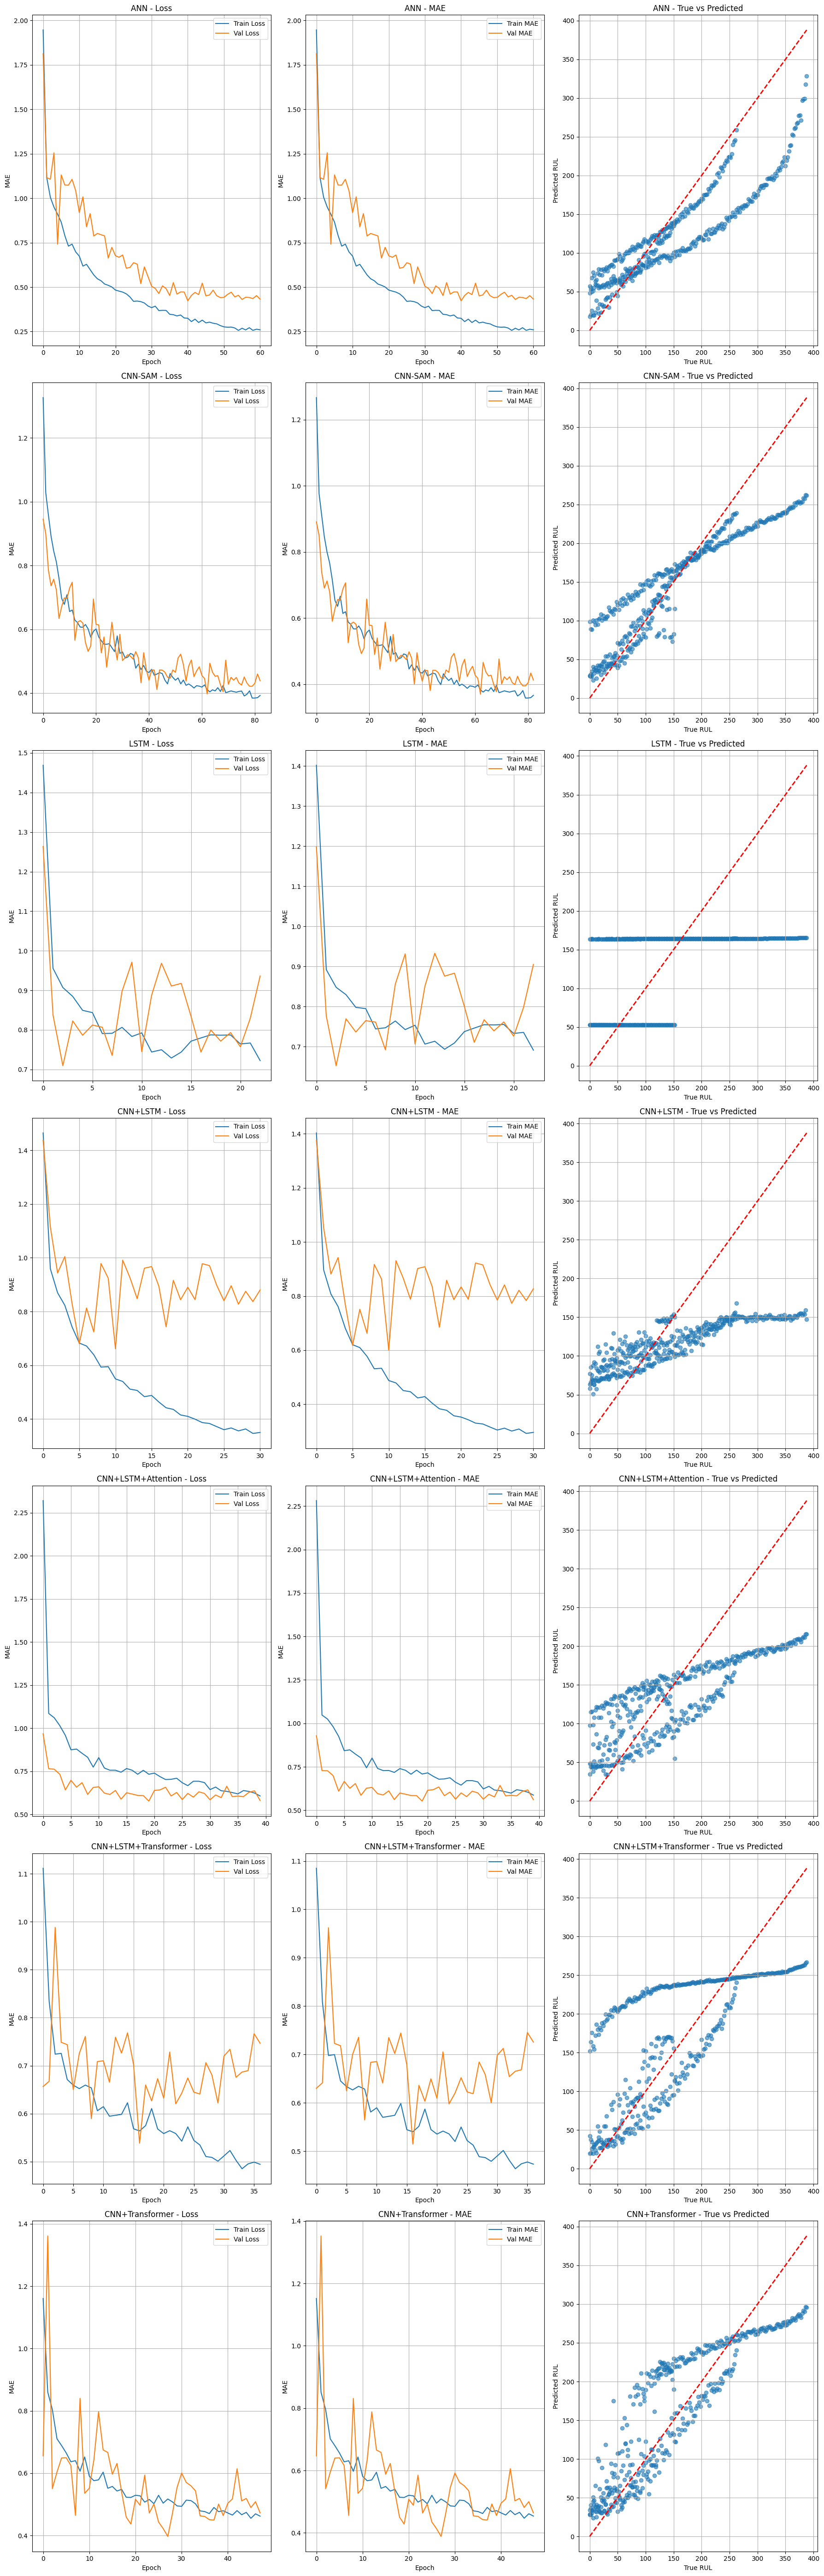

ANN - MSE: 3709.0046, RMSE: 60.9016, MAE: 45.6399, R²: 0.6463
CNN-SAM - MSE: 2373.6946, RMSE: 48.7206, MAE: 35.4797, R²: 0.7737
LSTM - MSE: 8168.2358, RMSE: 90.3783, MAE: 72.4216, R²: 0.2211
CNN+LSTM - MSE: 7623.9702, RMSE: 87.3153, MAE: 67.1091, R²: 0.2730
CNN+LSTM+Attention - MSE: 5249.5171, RMSE: 72.4536, MAE: 59.6412, R²: 0.4994
CNN+LSTM+Transformer - MSE: 5492.3730, RMSE: 74.1105, MAE: 57.5357, R²: 0.4763
CNN+Transformer - MSE: 2410.8762, RMSE: 49.1007, MAE: 39.4750, R²: 0.7701


In [33]:
# Plot Training History and True vs Predicted Results for trained models

fig, axes = plt.subplots(len(model_info), 3, figsize=(18, 8*len(model_info)))
if len(model_info) == 1:
    axes = np.array([axes])

for i, (model_name, model) in enumerate(model_info.items()):
    axes[i, 0].plot(model['history'].history['loss'], label='Train Loss')
    axes[i, 0].plot(model['history'].history['val_loss'], label='Val Loss')
    axes[i, 0].set_title(f'{model_name} - Loss')
    axes[i, 0].set_xlabel('Epoch')
    axes[i, 0].set_ylabel('MAE')
    axes[i, 0].legend()
    axes[i, 0].grid(True)

    axes[i, 1].plot(model['history'].history['mae'], label='Train MAE')
    axes[i, 1].plot(model['history'].history['val_mae'], label='Val MAE')
    axes[i, 1].set_title(f'{model_name} - MAE')
    axes[i, 1].set_xlabel('Epoch')
    axes[i, 1].set_ylabel('MAE')
    axes[i, 1].legend()
    axes[i, 1].grid(True)

    axes[i, 2].scatter(model['results'][0], model['results'][1], alpha=0.6)
    ymin, ymax = model['results'][0].min(), model['results'][0].max()
    axes[i, 2].plot([ymin, ymax], [ymin, ymax], 'r--', lw=2)
    axes[i, 2].set_xlabel('True RUL')
    axes[i, 2].set_ylabel('Predicted RUL')
    axes[i, 2].set_title(f'{model_name} - True vs Predicted')
    axes[i, 2].grid(True)

plt.tight_layout()
plt.show()

for model_name, model in model_info.items():
    print(f"{model_name} - MSE: {model['mse']:.4f}, RMSE: {model['rmse']:.4f}, MAE: {model['mae']:.4f}, R²: {model['r2']:.4f}")

25C05 - ANN R²: 0.735


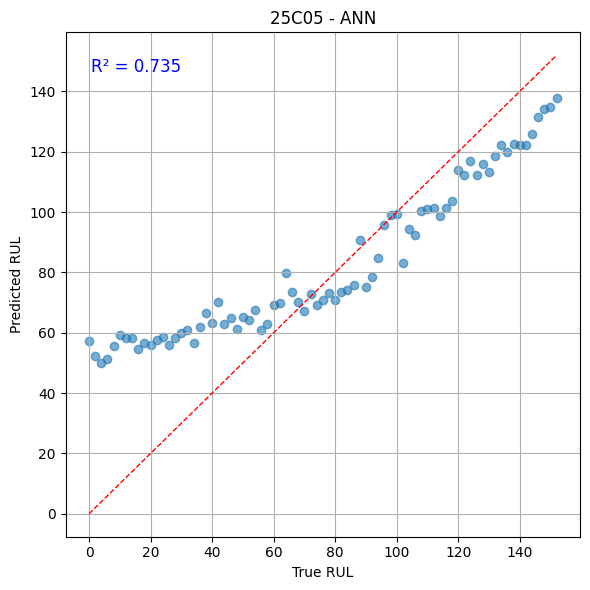

35C02 - ANN R²: 0.830


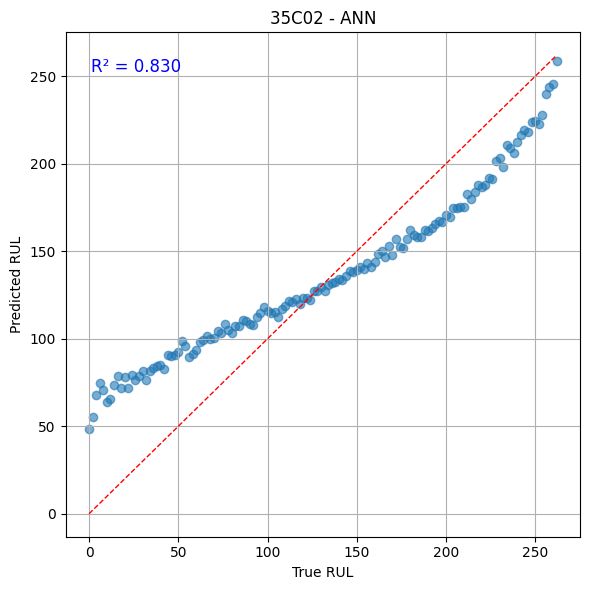

45C02 - ANN R²: 0.463


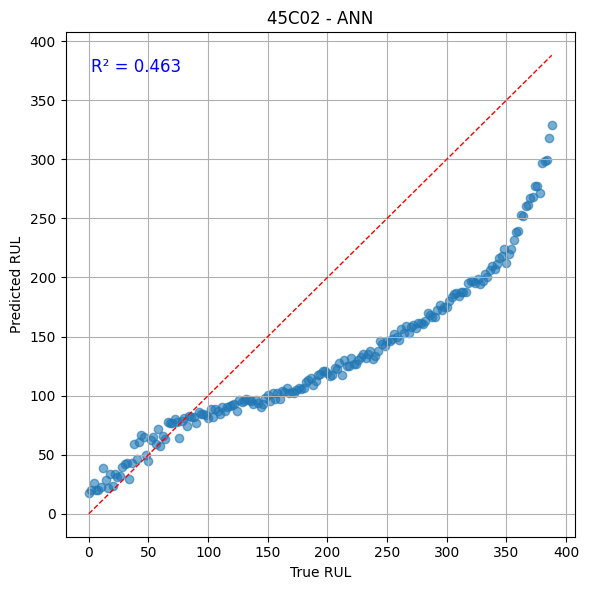

25C05 - CNN-SAM R²: 0.717


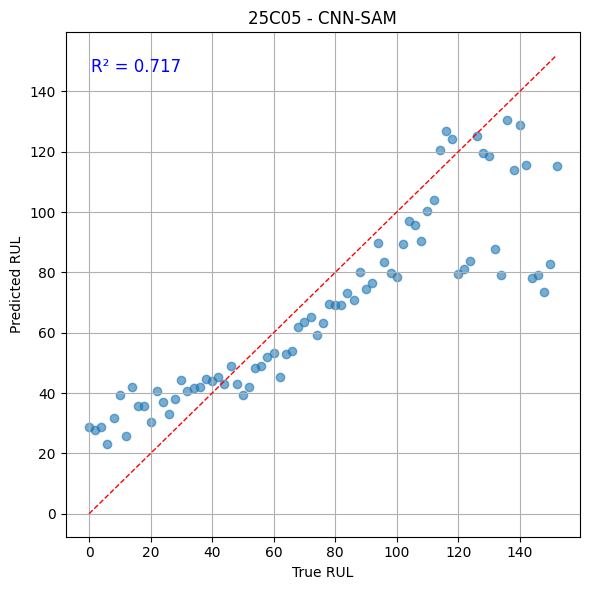

35C02 - CNN-SAM R²: 0.963


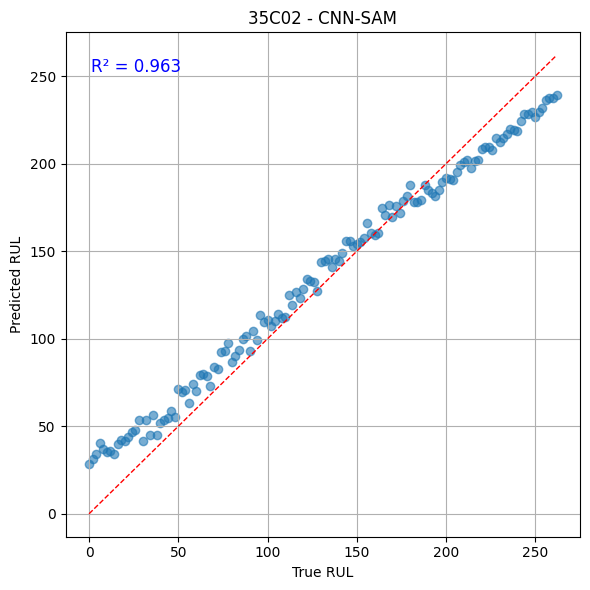

45C02 - CNN-SAM R²: 0.641


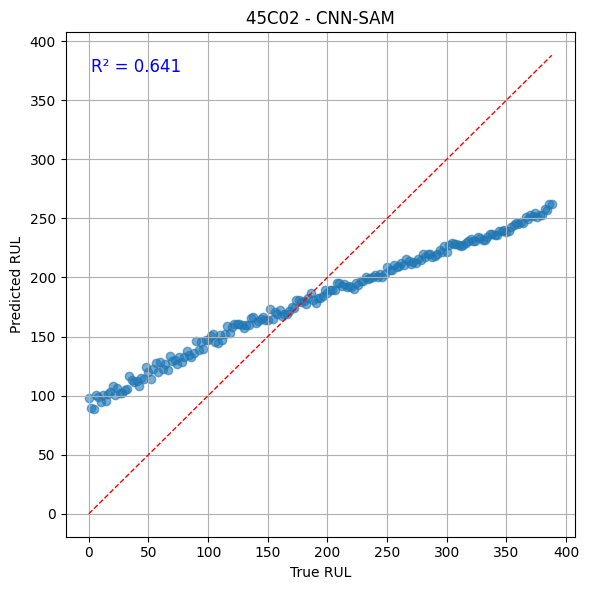

25C05 - LSTM R²: -0.279


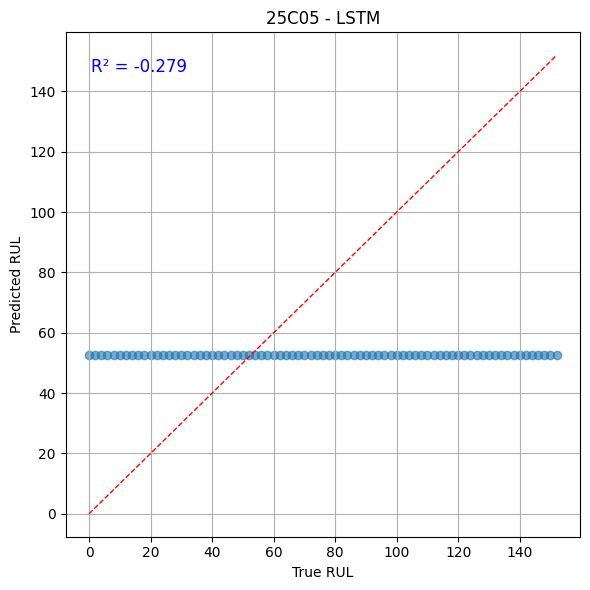

35C02 - LSTM R²: 0.327


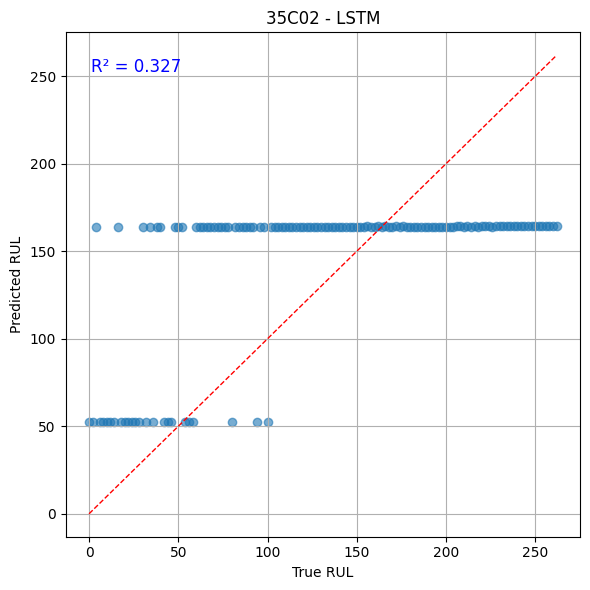

45C02 - LSTM R²: -0.048


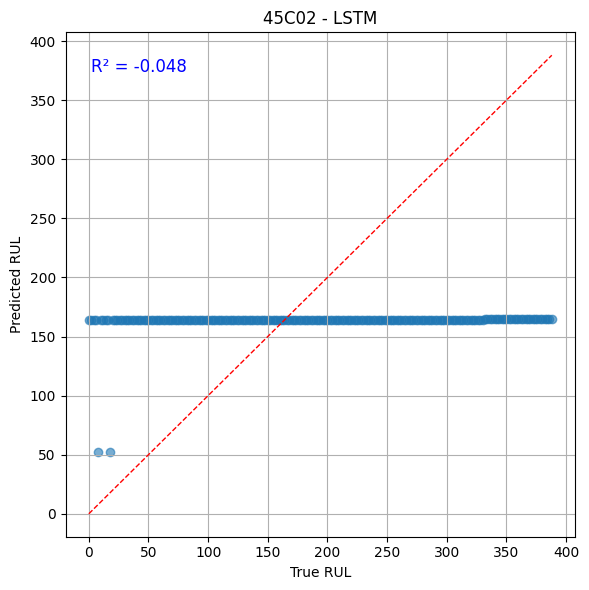

25C05 - CNN+LSTM R²: -0.029


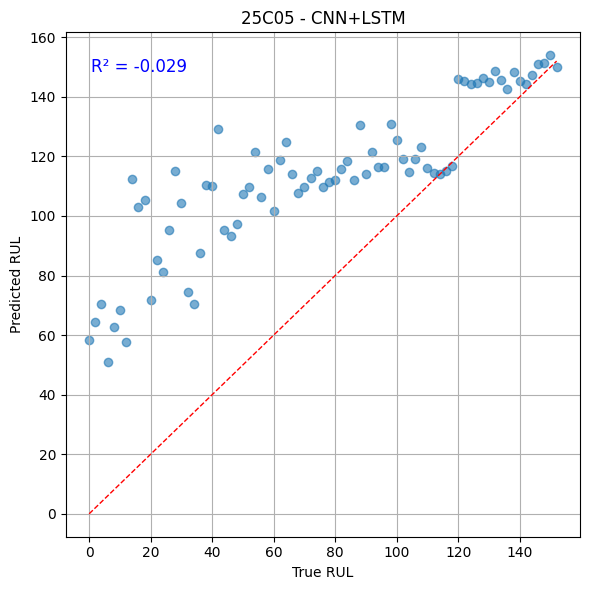

35C02 - CNN+LSTM R²: 0.426


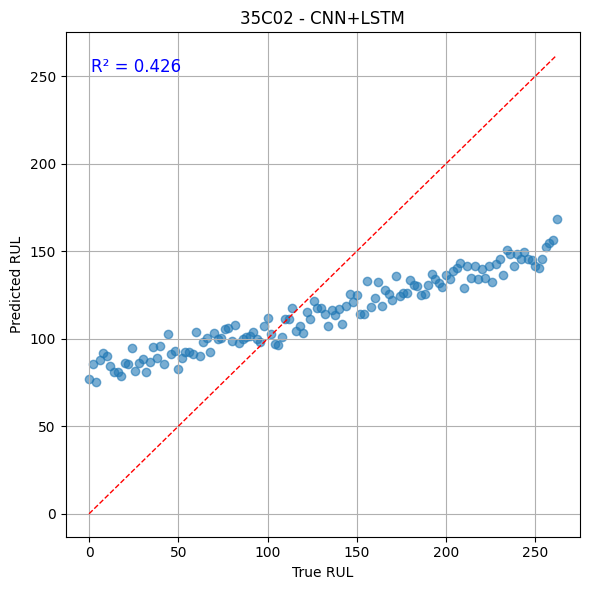

45C02 - CNN+LSTM R²: -0.005


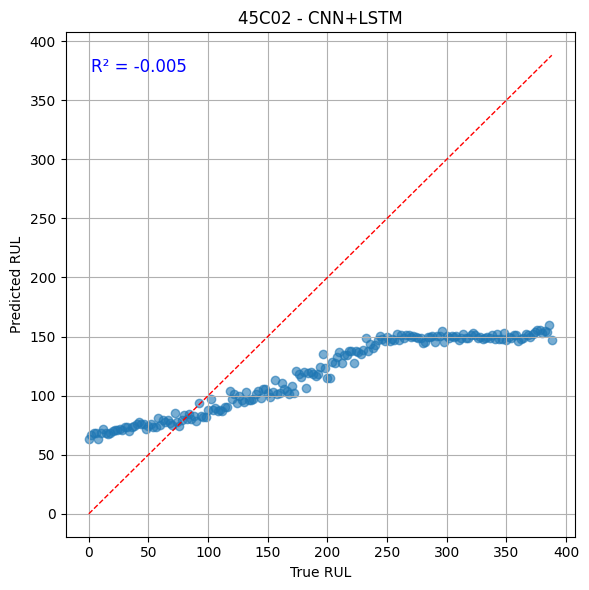

25C05 - CNN+LSTM+Attention R²: 0.235


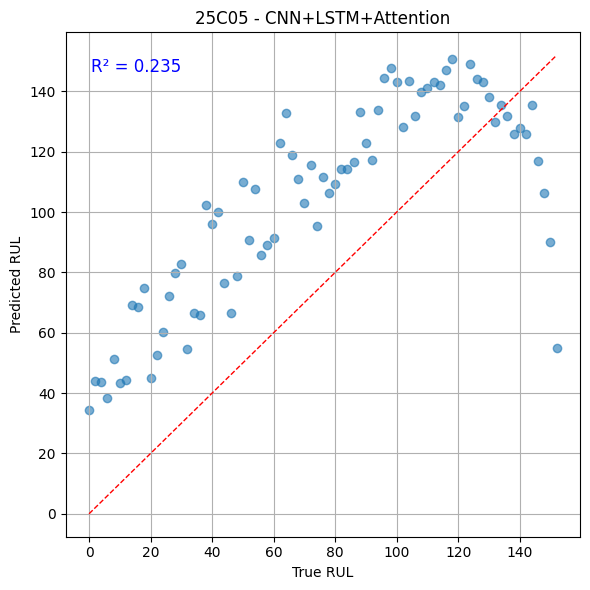

35C02 - CNN+LSTM+Attention R²: 0.430


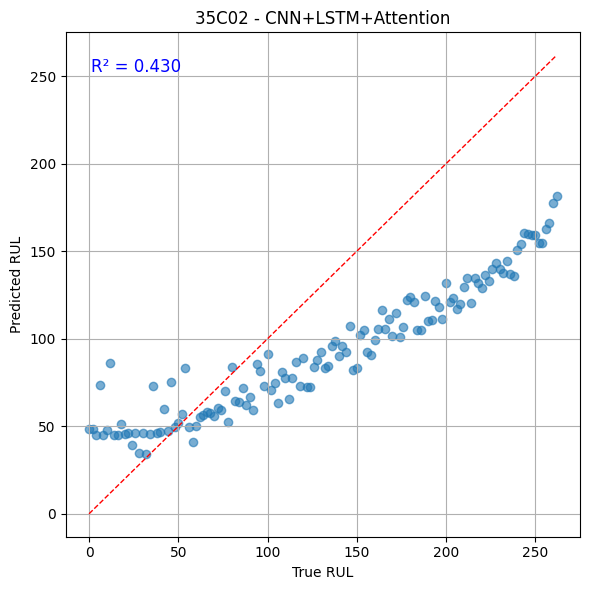

45C02 - CNN+LSTM+Attention R²: 0.366


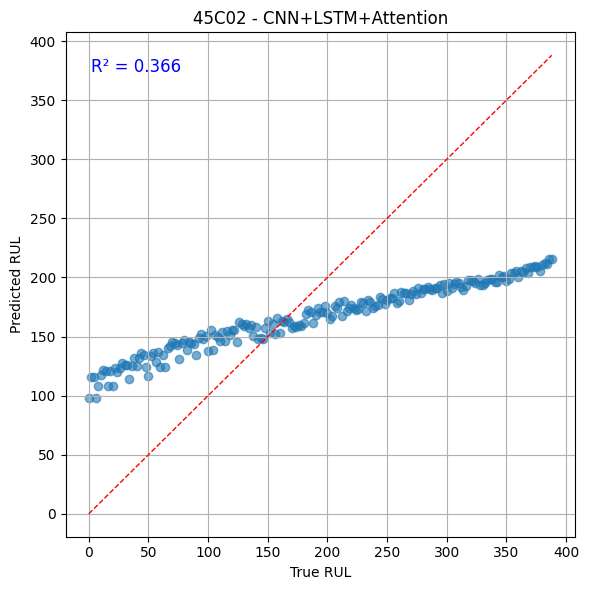

25C05 - CNN+LSTM+Transformer R²: 0.605


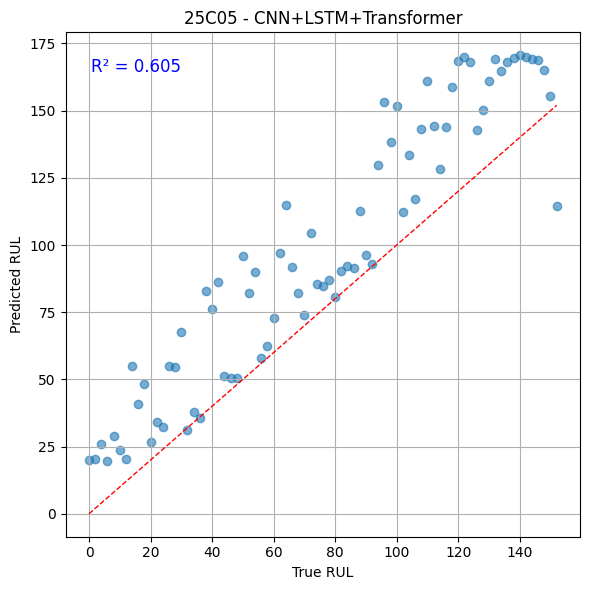

35C02 - CNN+LSTM+Transformer R²: 0.772


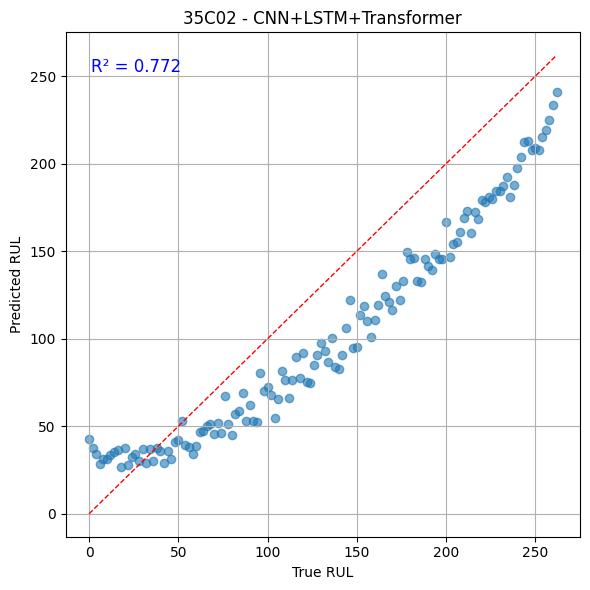

45C02 - CNN+LSTM+Transformer R²: 0.197


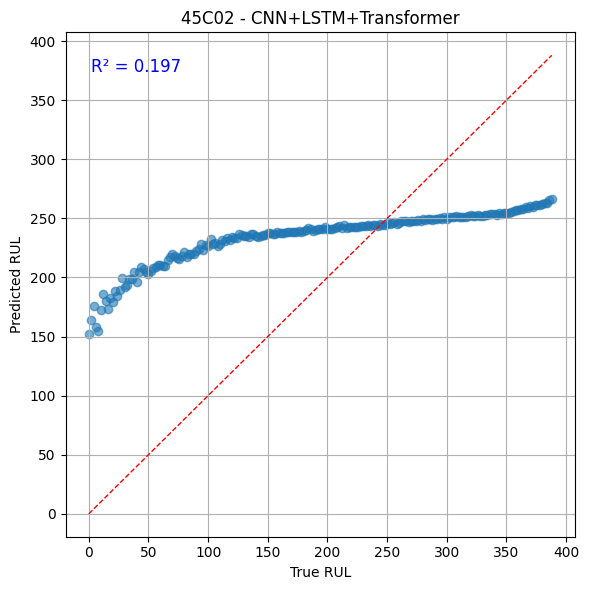

25C05 - CNN+Transformer R²: -0.270


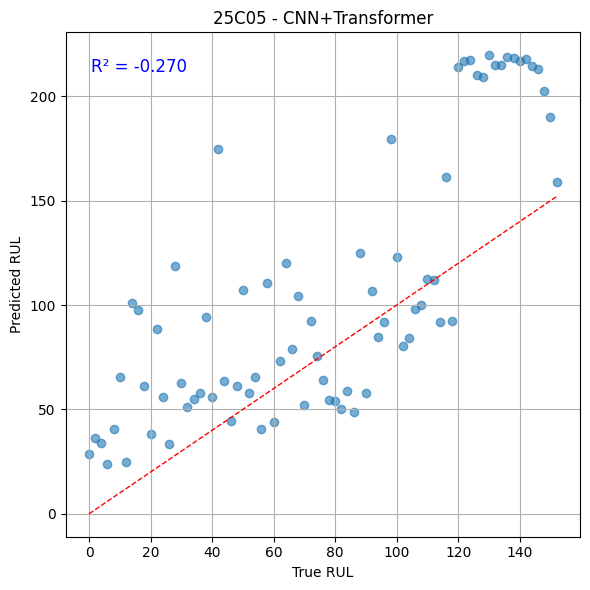

35C02 - CNN+Transformer R²: 0.895


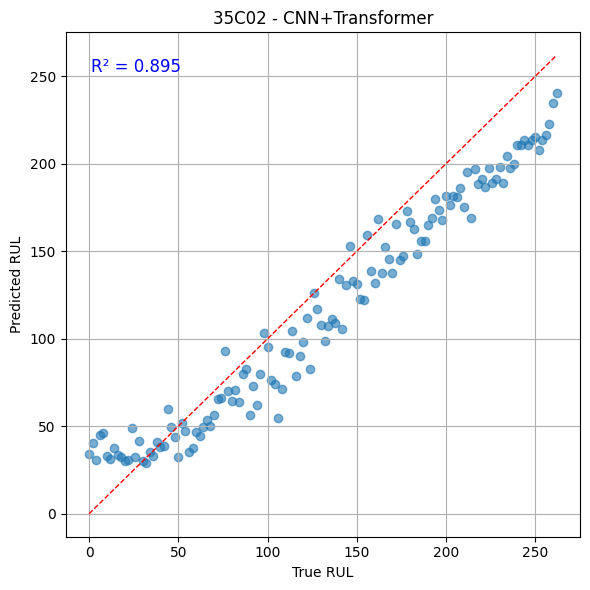

45C02 - CNN+Transformer R²: 0.717


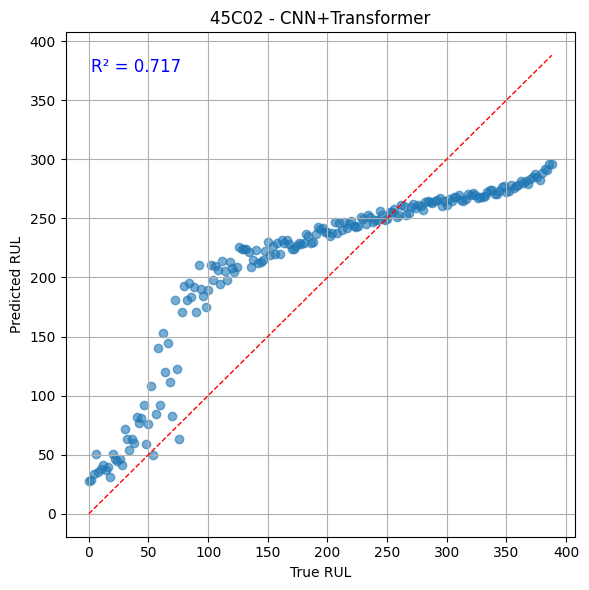

In [35]:
for model_name, model in model_info.items():
    for bat in testing_batteries:
        # Prepare dataset depending on model type
        if model_name == 'ANN':
            X, y = prepare_flatten_dataset(battery_data, [bat], features=FEATURES, frequencies_max=None)
        else:
            X, y = prepare_3d_dataset(battery_data, [bat], features=FEATURES, frequencies_max=None)

        # Scale + predict
        X = model['scaler'].transform(X)
        y_pred = model['model'].predict(X, verbose=0).flatten()
        y_pred = log_inverse(y_pred)

        # Metrics
        r2 = r2_score(y, y_pred)
        print(f"{bat} - {model_name} R²: {r2:.3f}")

        # Individual plot
        plt.figure(figsize=(6, 6))
        plt.scatter(y, y_pred, alpha=0.6)
        ymin, ymax = y.min(), y.max()
        plt.plot([ymin, ymax], [ymin, ymax], 'r--', lw=1)

        # Add title and R² text
        plt.title(f'{bat} - {model_name}')
        plt.xlabel('True RUL')
        plt.ylabel('Predicted RUL')
        plt.text(0.05, 0.95, f'R² = {r2:.3f}', 
                 transform=plt.gca().transAxes,
                 fontsize=12, color='blue', 
                 verticalalignment='top')

        plt.grid(True)
        plt.tight_layout()
        plt.show()